# CELL 1: Installation

In [1]:
import sys
import subprocess
import os

print("Installing P100-compatible PyTorch...")

# Uninstall current incompatible version
subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'torch', 'torchvision', 'torchaudio'])

# Install PyTorch 2.1.0 with CUDA 11.8 (Stable for P100/T4)
subprocess.check_call([
    sys.executable, '-m', 'pip', 'install',
    'torch==2.1.2+cu118', 
    'torchvision==0.16.2+cu118', 
    'torchaudio==2.1.2+cu118',
    '--extra-index-url', 'https://download.pytorch.org/whl/cu118'
])

# Verify installation
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

# Test tensor on GPU immediately
try:
    x = torch.randn(1).cuda()
    print("GPU Test: SUCCESS - Tensor moved to CUDA")
except Exception as e:
    print(f"GPU Test: FAILED - {e}")

# Fix numpy
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'numpy==1.26.4'])


Installing P100-compatible PyTorch...
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 612.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.

0

# CELL 2: Imports and Environment Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
from tqdm.auto import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, silhouette_score,
    classification_report
)
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print("ENVIRONMENT SETUP - TASK 5: BYOL")
print("."*80)
print(f"PyTorch version:       {torch.__version__}")
print(f"Torchvision version:   {torchvision.__version__}")
print(f"NumPy version:         {np.__version__}")
print(f"Device:                {device}")
if torch.cuda.is_available():
    print(f"GPU:                   {torch.cuda.get_device_name(0)}")
print("\nREADY FOR BYOL TRAINING")


ENVIRONMENT SETUP - TASK 5: BYOL
................................................................................
PyTorch version:       2.1.2+cu118
Torchvision version:   0.16.2+cu118
NumPy version:         1.26.4
Device:                cuda
GPU:                   Tesla P100-PCIE-16GB

READY FOR BYOL TRAINING


# CELL 3: BYOL Components

In [4]:
class BYOLProjectionHead(nn.Module):
    """BYOL Projection Head"""
    def __init__(self, input_dim=2048, hidden_dim=4096, output_dim=256):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.projection(x)


class BYOLPredictorHead(nn.Module):
    """BYOL Predictor Head (Only on Student)"""
    def __init__(self, input_dim=256, hidden_dim=4096, output_dim=256):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.predictor(x)


class LinearClassifier(nn.Module):
    """Linear probe classifier"""
    def __init__(self, input_dim=2048, num_classes=38):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.linear(x)


class MLPClassifier(nn.Module):
    """MLP classifier"""
    def __init__(self, input_dim=2048, hidden_dim=512, num_classes=38):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        return self.mlp(x)


def cosine_similarity_loss(x, y):
    """BYOL Loss: Cosine Similarity with negative sign"""
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    similarity = 2 - 2 * (x * y).sum(dim=-1)
    return similarity.mean()


print("BYOL components defined:")
print("  - BYOLProjectionHead")
print("  - BYOLPredictorHead")
print("  - LinearClassifier")
print("  - MLPClassifier")
print("  - cosine_similarity_loss")


BYOL components defined:
  - BYOLProjectionHead
  - BYOLPredictorHead
  - LinearClassifier
  - MLPClassifier
  - cosine_similarity_loss


# CELL 4: Rice Dataset (With Manual Tensor Conversion)

In [5]:
class RiceDataset(Dataset):
    """Rice dataset with numpy compatibility fix"""
    def __init__(self, root_dir, mode='ssl', split_ratio=0.7, train=True, seed=42):
        self.root_dir = Path(root_dir)
        self.mode = mode
        self.train = train
        
        self.image_paths = []
        self.labels = []
        
        self.class_names = sorted([d.name for d in self.root_dir.iterdir() 
                                   if d.is_dir() and not d.name.startswith('.')])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}
        self.num_classes = len(self.class_names)
        
        np.random.seed(seed)
        
        for class_name in self.class_names:
            class_dir = self.root_dir / class_name
            class_images = []
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                class_images.extend(list(class_dir.glob(ext)))
            
            class_images = sorted(class_images)
            if len(class_images) == 0:
                continue
            
            indices = np.arange(len(class_images))
            np.random.shuffle(indices)
            class_images = [class_images[i] for i in indices]
            
            split_idx = int(len(class_images) * split_ratio)
            selected_images = class_images[:split_idx] if train else class_images[split_idx:]
            
            self.image_paths.extend(selected_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(selected_images))
        
        print(f"{'Train' if train else 'Test'} dataset: {len(self.image_paths)} images, {self.num_classes} classes, mode: {mode}")
        self._setup_transforms()
    
    def _setup_transforms(self):
        if self.mode == 'ssl':
            self.base_transform = transforms.Compose([
                transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([
                    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
                ], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([
                    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))
                ], p=0.5)
            ])
        else:
            self.base_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224)
            ])
        
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def pil_to_tensor_manual(self, pil_img):
        """Manual PIL to tensor - avoids numpy bug"""
        img_np = np.array(pil_img, dtype='uint8')
        img_np = img_np.astype('float32') / 255.0
        if len(img_np.shape) == 3:
            img_np = np.transpose(img_np, (2, 0, 1))
        elif len(img_np.shape) == 2:
            img_np = np.expand_dims(img_np, axis=0)
        tensor = torch.from_numpy(img_np.copy())
        return tensor
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.mode == 'ssl':
            view1_pil = self.base_transform(image)
            view2_pil = self.base_transform(image)
            view1 = self.pil_to_tensor_manual(view1_pil)
            view2 = self.pil_to_tensor_manual(view2_pil)
            view1 = self.normalize(view1)
            view2 = self.normalize(view2)
            return view1, view2, label
        else:
            img_pil = self.base_transform(image)
            img_tensor = self.pil_to_tensor_manual(img_pil)
            img_tensor = self.normalize(img_tensor)
            return img_tensor, label

print("RiceDataset class defined with numpy compatibility fix")


RiceDataset class defined with numpy compatibility fix


# CELL 5: Dataset Path and Hyperparameters

In [6]:
DATASET_ROOT = '/kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Original'

print("="*80)
print("DATASET VERIFICATION")
print("="*80)

if not os.path.exists(DATASET_ROOT):
    print(f"ERROR: Dataset not found at {DATASET_ROOT}")
    raise FileNotFoundError(f"Dataset not found")
else:
    print(f"Dataset path: {DATASET_ROOT}")
    classes = sorted([d for d in os.listdir(DATASET_ROOT) 
                     if os.path.isdir(os.path.join(DATASET_ROOT, d)) and not d.startswith('.')])
    num_classes = len(classes)
    print(f"Number of classes: {num_classes}")
    total_images = sum(len([f for f in os.listdir(os.path.join(DATASET_ROOT, cls)) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) 
                      for cls in classes)
    print(f"Total images: {total_images}")

# Hyperparameters
NUM_CLASSES = 38
BATCH_SIZE = 64
PROJECTION_DIM = 256
HIDDEN_DIM = 4096
SSL_EPOCHS = 40  
LINEAR_PROBE_EPOCHS = 50
FINETUNE_EPOCHS = 30
LEARNING_RATE = 0.0005  # Reduced LR for stability
WEIGHT_DECAY = 1.5e-6
MOMENTUM = 0.99  # Momentum for EMA update
SPLIT_RATIO = 0.7

print("\n" + "="*80)
print("BYOL HYPERPARAMETERS")
print("="*80)
print(f"Batch size:            {BATCH_SIZE}")
print(f"Projection dim:        {PROJECTION_DIM}")
print(f"Hidden dim:            {HIDDEN_DIM}")
print(f"SSL epochs:            {SSL_EPOCHS}")
print(f"Learning rate:         {LEARNING_RATE}")
print(f"Weight decay:          {WEIGHT_DECAY}")
print(f"Momentum (EMA):        {MOMENTUM}")
print(f"Split ratio:           {SPLIT_RATIO}")



DATASET VERIFICATION
Dataset path: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Original
Number of classes: 38
Total images: 19000

BYOL HYPERPARAMETERS
Batch size:            64
Projection dim:        256
Hidden dim:            4096
SSL epochs:            40
Learning rate:         0.0005
Weight decay:          1.5e-06
Momentum (EMA):        0.99
Split ratio:           0.7


In [7]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    # Test CUDA functionality
    try:
        test_tensor = torch.randn(10, 10).cuda()
        result = test_tensor @ test_tensor.T
        print("CUDA test: SUCCESS")
        del test_tensor, result
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"CUDA test FAILED: {e}")
        print("FALLING BACK TO CPU MODE")

# Set device properly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


PyTorch version: 2.1.2+cu118
CUDA available: True
CUDA version: 11.8
GPU: Tesla P100-PCIE-16GB
CUDA test: SUCCESS

Using device: cuda


# CELL 6: BYOL Model Definition

In [8]:
print("="*80)
print("BYOL MODEL INITIALIZATION")
print("="*80)

class BYOL(nn.Module):
    """BYOL: Bootstrap Your Own Latent"""
    def __init__(self, projection_dim=256, hidden_dim=4096, momentum=0.99):
        super().__init__()
        self.momentum = momentum
        
        # Student network
        resnet = models.resnet50(pretrained=True)
        self.student_encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.student_projection = BYOLProjectionHead(input_dim=2048, hidden_dim=hidden_dim, output_dim=projection_dim)
        self.student_predictor = BYOLPredictorHead(input_dim=projection_dim, hidden_dim=hidden_dim, output_dim=projection_dim)
        
        # Teacher network
        resnet_teacher = models.resnet50(pretrained=True)
        self.teacher_encoder = nn.Sequential(*list(resnet_teacher.children())[:-1])
        self.teacher_projection = BYOLProjectionHead(input_dim=2048, hidden_dim=hidden_dim, output_dim=projection_dim)
        
        # Initialize teacher
        self._initialize_teacher()
        
        # Freeze teacher
        for param in self.teacher_encoder.parameters():
            param.requires_grad = False
        for param in self.teacher_projection.parameters():
            param.requires_grad = False
            
    def _initialize_teacher(self):
        for sp, tp in zip(self.student_encoder.parameters(), self.teacher_encoder.parameters()):
            tp.data.copy_(sp.data)
        for sp, tp in zip(self.student_projection.parameters(), self.teacher_projection.parameters()):
            tp.data.copy_(sp.data)
            
    @torch.no_grad()
    def update_teacher(self):
        for sp, tp in zip(self.student_encoder.parameters(), self.teacher_encoder.parameters()):
            tp.data = self.momentum * tp.data + (1 - self.momentum) * sp.data
        for sp, tp in zip(self.student_projection.parameters(), self.teacher_projection.parameters()):
            tp.data = self.momentum * tp.data + (1 - self.momentum) * sp.data
            
    def forward(self, x1, x2):
        # Student
        s_h1 = self.student_encoder(x1).flatten(1)
        s_z1 = self.student_projection(s_h1)
        s_p1 = self.student_predictor(s_z1)
        
        s_h2 = self.student_encoder(x2).flatten(1)
        s_z2 = self.student_projection(s_h2)
        s_p2 = self.student_predictor(s_z2)
        
        # Teacher
        with torch.no_grad():
            t_h1 = self.teacher_encoder(x1).flatten(1)
            t_z1 = self.teacher_projection(t_h1)
            t_h2 = self.teacher_encoder(x2).flatten(1)
            t_z2 = self.teacher_projection(t_h2)
            
        loss1 = cosine_similarity_loss(s_p1, t_z2)
        loss2 = cosine_similarity_loss(s_p2, t_z1)
        return (loss1 + loss2) / 2, s_h1

    def extract_features(self, x):
        return self.student_encoder(x).flatten(1)

# Initialize directly on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Initializing model on {device}...")

byol_model = BYOL(projection_dim=PROJECTION_DIM, hidden_dim=HIDDEN_DIM, momentum=MOMENTUM).to(device)

print(f"BYOL Model Ready on {device}")
if device.type == 'cuda':
    print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")


BYOL MODEL INITIALIZATION
Initializing model on cuda...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


BYOL Model Ready on cuda
GPU Memory: 0.26 GB


# CELL 7: BYOL Pretraining

In [9]:
print("."*80)
print("BYOL PRETRAINING")
print("."*80)

ssl_train_dataset = RiceDataset(DATASET_ROOT, mode='ssl', split_ratio=SPLIT_RATIO, train=True, seed=42)
ssl_train_loader = DataLoader(ssl_train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=0, pin_memory=(device.type=='cuda'), drop_last=True)

optimizer = torch.optim.Adam(byol_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=SSL_EPOCHS)

byol_history = {'epoch': [], 'loss': [], 'learning_rate': [], 'time': []}

print(f"Starting training on {device}...")
byol_model.train()
global_start_time = time.time()

for epoch in range(SSL_EPOCHS):
    epoch_start = time.time()
    running_loss = 0.0
    num_batches = 0
    cuda_error_count = 0
    
    progress_bar = tqdm(ssl_train_loader, desc=f"Epoch {epoch+1}/{SSL_EPOCHS}")
    
    for batch_idx, (view1, view2, _) in enumerate(progress_bar):
        try:
            # Move to device
            view1 = view1.to(device, non_blocking=False)
            view2 = view2.to(device, non_blocking=False)
            
            # Forward pass
            loss, _ = byol_model(view1, view2)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update teacher
            byol_model.update_teacher()
            
            running_loss += loss.item()
            num_batches += 1
            
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}", 'avg': f"{running_loss/num_batches:.4f}"})
            
        except RuntimeError as e:
            if 'CUDA' in str(e) or 'out of memory' in str(e):
                cuda_error_count += 1
                if cuda_error_count > 5:
                    print(f"\nToo many CUDA errors ({cuda_error_count}). Stopping training.")
                    print("Try reducing BATCH_SIZE or restart kernel.")
                    break
                torch.cuda.empty_cache()
                continue
            else:
                raise e
    
    if cuda_error_count > 5:
        break
    
    scheduler.step()
    
    if num_batches > 0:
        epoch_loss = running_loss / num_batches
        epoch_time = time.time() - epoch_start
        
        byol_history['epoch'].append(epoch + 1)
        byol_history['loss'].append(epoch_loss)
        byol_history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        byol_history['time'].append(epoch_time)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            elapsed = time.time() - global_start_time
            remaining = (elapsed / (epoch + 1)) * (SSL_EPOCHS - epoch - 1)
            print(f"\nEpoch {epoch+1}: Loss={epoch_loss:.4f}, Time={epoch_time:.2f}s, " +
                  f"Elapsed={elapsed/3600:.1f}h, Remaining={remaining/3600:.1f}h")

total_time = time.time() - global_start_time
print(f"\nTraining completed in {total_time/3600:.2f} hours")

# Save
torch.save({
    'epoch': len(byol_history['epoch']),
    'student_encoder_state_dict': byol_model.student_encoder.state_dict(),
    'student_projection_state_dict': byol_model.student_projection.state_dict(),
    'byol_history': byol_history,
    'hyperparameters': {
        'batch_size': BATCH_SIZE, 'projection_dim': PROJECTION_DIM,
        'hidden_dim': HIDDEN_DIM, 'momentum': MOMENTUM,
        'learning_rate': LEARNING_RATE, 'epochs': len(byol_history['epoch'])
    }
}, 'byol_pretrained_encoder.pth')

print("Saved: byol_pretrained_encoder.pth")


................................................................................
BYOL PRETRAINING
................................................................................
Train dataset: 13300 images, 38 classes, mode: ssl
Starting training on cuda...


Epoch 1/40:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 1: Loss=0.3545, Time=792.47s, Elapsed=0.2h, Remaining=8.6h


Epoch 2/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 3/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 4/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 5/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 6/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 7/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 8/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 9/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 10/40:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 10: Loss=0.0760, Time=756.05s, Elapsed=2.1h, Remaining=6.3h


Epoch 11/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 12/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 13/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 14/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 15/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 16/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 17/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 18/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 19/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 20/40:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 20: Loss=0.0606, Time=724.40s, Elapsed=4.1h, Remaining=4.1h


Epoch 21/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 22/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 23/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 24/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 25/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 26/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 27/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 28/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 29/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 30/40:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 30: Loss=0.0566, Time=737.94s, Elapsed=6.2h, Remaining=2.1h


Epoch 31/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 32/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 33/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 34/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 35/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 36/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 37/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 38/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 39/40:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 40/40:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 40: Loss=0.0504, Time=736.95s, Elapsed=8.3h, Remaining=0.0h

Training completed in 8.27 hours
Saved: byol_pretrained_encoder.pth


# CELL 8: Training Visualization

................................................................................
BYOL TRAINING VISUALIZATION
................................................................................


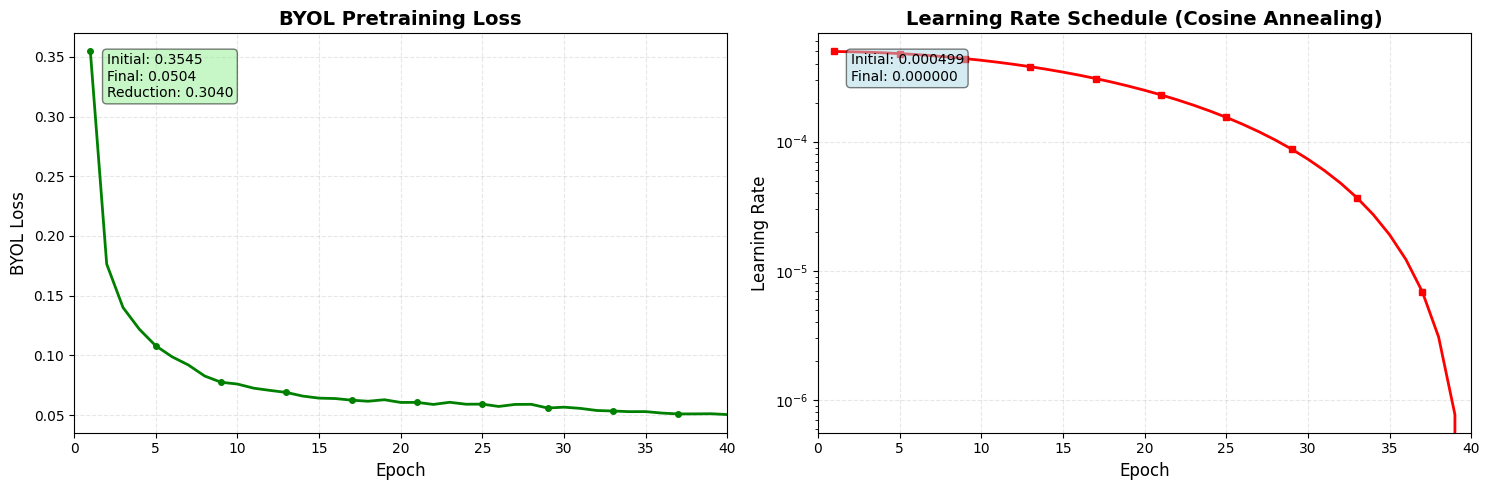

Training summary:
  Epochs: 40
  Final loss: 0.0504
  Avg epoch time: 744.11s
  Total time: 8.27h


In [10]:
print("."*80)
print("BYOL TRAINING VISUALIZATION")
print("."*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(byol_history['epoch'], byol_history['loss'], 
            'g-', linewidth=2, marker='o', markersize=4, markevery=max(1, len(byol_history['epoch'])//10))
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('BYOL Loss', fontsize=12)
axes[0].set_title('BYOL Pretraining Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlim(0, max(byol_history['epoch']))

initial_loss = byol_history['loss'][0]
final_loss = byol_history['loss'][-1]
axes[0].text(0.05, 0.95, f'Initial: {initial_loss:.4f}\nFinal: {final_loss:.4f}\nReduction: {initial_loss-final_loss:.4f}',
            transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Learning rate curve
axes[1].plot(byol_history['epoch'], byol_history['learning_rate'], 
            'r-', linewidth=2, marker='s', markersize=4, markevery=max(1, len(byol_history['epoch'])//10))
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule (Cosine Annealing)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xlim(0, max(byol_history['epoch']))
axes[1].set_yscale('log')

initial_lr = byol_history['learning_rate'][0]
final_lr = byol_history['learning_rate'][-1]
axes[1].text(0.05, 0.95, f'Initial: {initial_lr:.6f}\nFinal: {final_lr:.6f}',
            transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig('byol_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training summary:")
print(f"  Epochs: {len(byol_history['epoch'])}")
print(f"  Final loss: {byol_history['loss'][-1]:.4f}")
print(f"  Avg epoch time: {np.mean(byol_history['time']):.2f}s")
print(f"  Total time: {sum(byol_history['time'])/3600:.2f}h")


# CELL 9: Feature Extraction

In [11]:
print("="*80)
print("FEATURE EXTRACTION - BYOL")
print("="*80)

def extract_features_byol(model, data_loader, device):
    """Extract features from BYOL student encoder"""
    model.eval()
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc="Extracting features"):
            images = images.to(device, non_blocking=True)
            h = model.extract_features(images)
            features_list.append(h.cpu())
            labels_list.append(lbls)
    
    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return features, labels

eval_train_dataset = RiceDataset(DATASET_ROOT, mode='eval', split_ratio=SPLIT_RATIO, train=True, seed=42)
eval_test_dataset = RiceDataset(DATASET_ROOT, mode='eval', split_ratio=SPLIT_RATIO, train=False, seed=42)

eval_train_loader = DataLoader(eval_train_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0, pin_memory=True)
eval_test_loader = DataLoader(eval_test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0, pin_memory=True)

# Extract features
print("\nExtracting train features...")
train_features, train_labels = extract_features_byol(byol_model, eval_train_loader, device)
print("Extracting test features...")
test_features, test_labels = extract_features_byol(byol_model, eval_test_loader, device)

print(f"\nTrain features: {train_features.shape}")
print(f"Test features:  {test_features.shape}")

# Save features
torch.save({'train_features': train_features, 'train_labels': train_labels,
            'test_features': test_features, 'test_labels': test_labels,
            'class_names': eval_train_dataset.class_names}, 'byol_features.pth')
print("Saved: byol_features.pth")


FEATURE EXTRACTION - BYOL
Train dataset: 13300 images, 38 classes, mode: eval
Test dataset: 5700 images, 38 classes, mode: eval

Extracting train features...


Extracting features:   0%|          | 0/104 [00:00<?, ?it/s]

Extracting test features...


Extracting features:   0%|          | 0/45 [00:00<?, ?it/s]


Train features: torch.Size([13300, 2048])
Test features:  torch.Size([5700, 2048])
Saved: byol_features.pth


# CELL 10: Linear Probe Evaluation

In [12]:
print("="*80)
print("LINEAR PROBE EVALUATION - BYOL")
print("="*80)

class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

feature_train_dataset = FeatureDataset(train_features, train_labels)
feature_test_dataset = FeatureDataset(test_features, test_labels)

feature_train_loader = DataLoader(feature_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
feature_test_loader = DataLoader(feature_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

linear_classifier = LinearClassifier(input_dim=2048, num_classes=NUM_CLASSES).to(device)
criterion_ce = nn.CrossEntropyLoss()
optimizer_linear = torch.optim.Adam(linear_classifier.parameters(), lr=0.001)

linear_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
print("Training linear probe...")
for epoch in range(LINEAR_PROBE_EPOCHS):
    linear_classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for features, labels in feature_train_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = linear_classifier(features)
        loss = criterion_ce(outputs, labels)
        optimizer_linear.zero_grad()
        loss.backward()
        optimizer_linear.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    train_loss /= len(feature_train_loader)
    train_acc = 100. * train_correct / train_total
    linear_history['train_loss'].append(train_loss)
    linear_history['train_acc'].append(train_acc)
    
    linear_classifier.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for features, labels in feature_test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = linear_classifier(features)
            loss = criterion_ce(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_loss /= len(feature_test_loader)
    val_acc = 100. * val_correct / val_total
    linear_history['val_loss'].append(val_loss)
    linear_history['val_acc'].append(val_acc)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{LINEAR_PROBE_EPOCHS}: Train Acc={train_acc:.2f}% Val Acc={val_acc:.2f}%")

print(f"\nLinear Probe Final Accuracy: {val_acc:.2f}%")
torch.save(linear_classifier.state_dict(), 'byol_linear_classifier.pth')


LINEAR PROBE EVALUATION - BYOL
Training linear probe...
Epoch 10/50: Train Acc=55.03% Val Acc=52.77%
Epoch 20/50: Train Acc=60.97% Val Acc=58.44%
Epoch 30/50: Train Acc=63.90% Val Acc=58.11%
Epoch 40/50: Train Acc=66.68% Val Acc=62.67%
Epoch 50/50: Train Acc=68.41% Val Acc=64.65%

Linear Probe Final Accuracy: 64.65%


# CELL 11: Shallow Classifiers

In [13]:
print("="*80)
print("SHALLOW CLASSIFIERS - BYOL FEATURES")
print("="*80)

X_train = train_features.numpy()
y_train = train_labels.numpy()
X_test = test_features.numpy()
y_test = test_labels.numpy()

shallow_results = {}

# MLP
print("1. MLP Classifier")
mlp_classifier = MLPClassifier(input_dim=2048, hidden_dim=512, num_classes=NUM_CLASSES).to(device)
optimizer_mlp = torch.optim.Adam(mlp_classifier.parameters(), lr=0.001)
for epoch in range(30):
    mlp_classifier.train()
    for features, labels in feature_train_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = mlp_classifier(features)
        loss = criterion_ce(outputs, labels)
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()

mlp_classifier.eval()
mlp_preds = []
with torch.no_grad():
    for features, _ in feature_test_loader:
        features = features.to(device)
        outputs = mlp_classifier(features)
        mlp_preds.append(outputs.argmax(dim=1).cpu())
mlp_preds = torch.cat(mlp_preds).numpy()
mlp_acc = accuracy_score(y_test, mlp_preds)
mlp_prec, mlp_rec, mlp_f1, _ = precision_recall_fscore_support(y_test, mlp_preds, average='weighted', zero_division=0)
shallow_results['MLP'] = {'accuracy': mlp_acc, 'precision': mlp_prec, 'recall': mlp_rec, 'f1': mlp_f1}
print(f"MLP Accuracy: {mlp_acc*100:.2f}%")

# SVM
print("\n2. SVM Classifier")
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(X_train, y_train)
svm_preds = svm_classifier.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
svm_prec, svm_rec, svm_f1, _ = precision_recall_fscore_support(y_test, svm_preds, average='weighted', zero_division=0)
shallow_results['SVM'] = {'accuracy': svm_acc, 'precision': svm_prec, 'recall': svm_rec, 'f1': svm_f1}
print(f"SVM Accuracy: {svm_acc*100:.2f}%")

# Decision Tree
print("\n3. Decision Tree")
dt_classifier = DecisionTreeClassifier(max_depth=20, random_state=42)
dt_classifier.fit(X_train, y_train)
dt_preds = dt_classifier.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
dt_prec, dt_rec, dt_f1, _ = precision_recall_fscore_support(y_test, dt_preds, average='weighted', zero_division=0)
shallow_results['Decision Tree'] = {'accuracy': dt_acc, 'precision': dt_prec, 'recall': dt_rec, 'f1': dt_f1}
print(f"Decision Tree Accuracy: {dt_acc*100:.2f}%")

# Random Forest
print("\n4. Random Forest")
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)
rf_preds = rf_classifier.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
rf_prec, rf_rec, rf_f1, _ = precision_recall_fscore_support(y_test, rf_preds, average='weighted', zero_division=0)
shallow_results['Random Forest'] = {'accuracy': rf_acc, 'precision': rf_prec, 'recall': rf_rec, 'f1': rf_f1}
print(f"Random Forest Accuracy: {rf_acc*100:.2f}%")

print("\n" + "="*80)
print("SHALLOW CLASSIFIERS SUMMARY")
print("="*80)
for name, metrics in shallow_results.items():
    print(f"{name:<20} Acc: {metrics['accuracy']*100:.2f}% F1: {metrics['f1']:.4f}")


SHALLOW CLASSIFIERS - BYOL FEATURES
1. MLP Classifier
MLP Accuracy: 72.75%

2. SVM Classifier
SVM Accuracy: 54.60%

3. Decision Tree
Decision Tree Accuracy: 40.88%

4. Random Forest
Random Forest Accuracy: 59.96%

SHALLOW CLASSIFIERS SUMMARY
MLP                  Acc: 72.75% F1: 0.7245
SVM                  Acc: 54.60% F1: 0.5406
Decision Tree        Acc: 40.88% F1: 0.4094
Random Forest        Acc: 59.96% F1: 0.5937


In [15]:
print("="*80)
print("FINE-TUNING - BYOL PRETRAINED ENCODER")
print("="*80)

# Load checkpoint
checkpoint = torch.load('byol_pretrained_encoder.pth')

# Create new model with classification head
byol_finetune = BYOL(projection_dim=PROJECTION_DIM, hidden_dim=HIDDEN_DIM, momentum=MOMENTUM).to(device)

# Load student encoder weights
byol_finetune.student_encoder.load_state_dict(checkpoint['student_encoder_state_dict'])
byol_finetune.student_projection.load_state_dict(checkpoint['student_projection_state_dict'])

# Replace predictor with classification head
byol_finetune.student_predictor = nn.Linear(PROJECTION_DIM, NUM_CLASSES).to(device)

print(f"Loaded pretrained weights")
print(f"Replaced predictor with classification head ({PROJECTION_DIM} → {NUM_CLASSES})")

# Enable training
for param in byol_finetune.parameters():
    param.requires_grad = True

# Separate parameter groups for different learning rates
param_groups = [
    {'params': list(byol_finetune.student_encoder.parameters()), 'lr': 0.00001},  # Frozen backbone, very low LR
    {'params': list(byol_finetune.student_projection.parameters()), 'lr': 0.0001},  # Slow learning
    {'params': list(byol_finetune.student_predictor.parameters()), 'lr': 0.001}  # Fast learning for classification head
]

optimizer_finetune = torch.optim.Adam(param_groups, weight_decay=1e-6)
scheduler_finetune = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_finetune, T_max=FINETUNE_EPOCHS)
criterion_ce = nn.CrossEntropyLoss()

finetune_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"Fine-tuning...")
print(f"Epochs: {FINETUNE_EPOCHS}")
print(f"Learning rates: Encoder=1e-5, Projection=1e-4, Predictor=1e-3")

for epoch in range(FINETUNE_EPOCHS):
    byol_finetune.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in tqdm(eval_train_loader, desc=f"Epoch {epoch+1}/{FINETUNE_EPOCHS}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass through encoder and projection
        h = byol_finetune.student_encoder(images)
        h = torch.flatten(h, start_dim=1)
        z = byol_finetune.student_projection(h)
        logits = byol_finetune.student_predictor(z)
        
        loss = criterion_ce(logits, labels)
        
        optimizer_finetune.zero_grad()
        loss.backward()
        optimizer_finetune.step()
        
        train_loss += loss.item()
        _, predicted = logits.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(eval_train_loader)
    train_acc = 100. * train_correct / train_total
    finetune_history['train_loss'].append(train_loss)
    finetune_history['train_acc'].append(train_acc)
    
    # Validation
    byol_finetune.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in eval_test_loader:
            images, labels = images.to(device), labels.to(device)
            
            h = byol_finetune.student_encoder(images)
            h = torch.flatten(h, start_dim=1)
            z = byol_finetune.student_projection(h)
            logits = byol_finetune.student_predictor(z)
            
            loss = criterion_ce(logits, labels)
            val_loss += loss.item()
            _, predicted = logits.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(eval_test_loader)
    val_acc = 100. * val_correct / val_total
    finetune_history['val_loss'].append(val_loss)
    finetune_history['val_acc'].append(val_acc)
    
    scheduler_finetune.step()
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{FINETUNE_EPOCHS}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

print(f"\nFine-Tuning Completed")
print(f"Final Training Accuracy:   {finetune_history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {finetune_history['val_acc'][-1]:.2f}%")

# Save finetuned model
torch.save({
    'student_encoder_state_dict': byol_finetune.student_encoder.state_dict(),
    'student_projection_state_dict': byol_finetune.student_projection.state_dict(),
    'student_predictor_state_dict': byol_finetune.student_predictor.state_dict(),
    'finetune_history': finetune_history
}, 'byol_finetuned.pth')

print("Saved: byol_finetuned.pth")


FINE-TUNING - BYOL PRETRAINED ENCODER
Loaded pretrained weights
Replaced predictor with classification head (256 → 38)
Fine-tuning...
Epochs: 30
Learning rates: Encoder=1e-5, Projection=1e-4, Predictor=1e-3


Epoch 1/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5/30: Train Acc=0.23%, Val Acc=11.77%


Epoch 6/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10/30: Train Acc=2.63%, Val Acc=6.91%


Epoch 11/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 15/30: Train Acc=3.38%, Val Acc=12.79%


Epoch 16/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 20/30: Train Acc=7.23%, Val Acc=13.65%


Epoch 21/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 25/30: Train Acc=13.17%, Val Acc=13.21%


Epoch 26/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 30/30: Train Acc=17.02%, Val Acc=13.40%

Fine-Tuning Completed
Final Training Accuracy:   17.02%
Final Validation Accuracy: 13.40%
Saved: byol_finetuned.pth


# CELL 13: Confusion Matrix & Per-Class Accuracy

CONFUSION MATRIX - BYOL FINE-TUNED


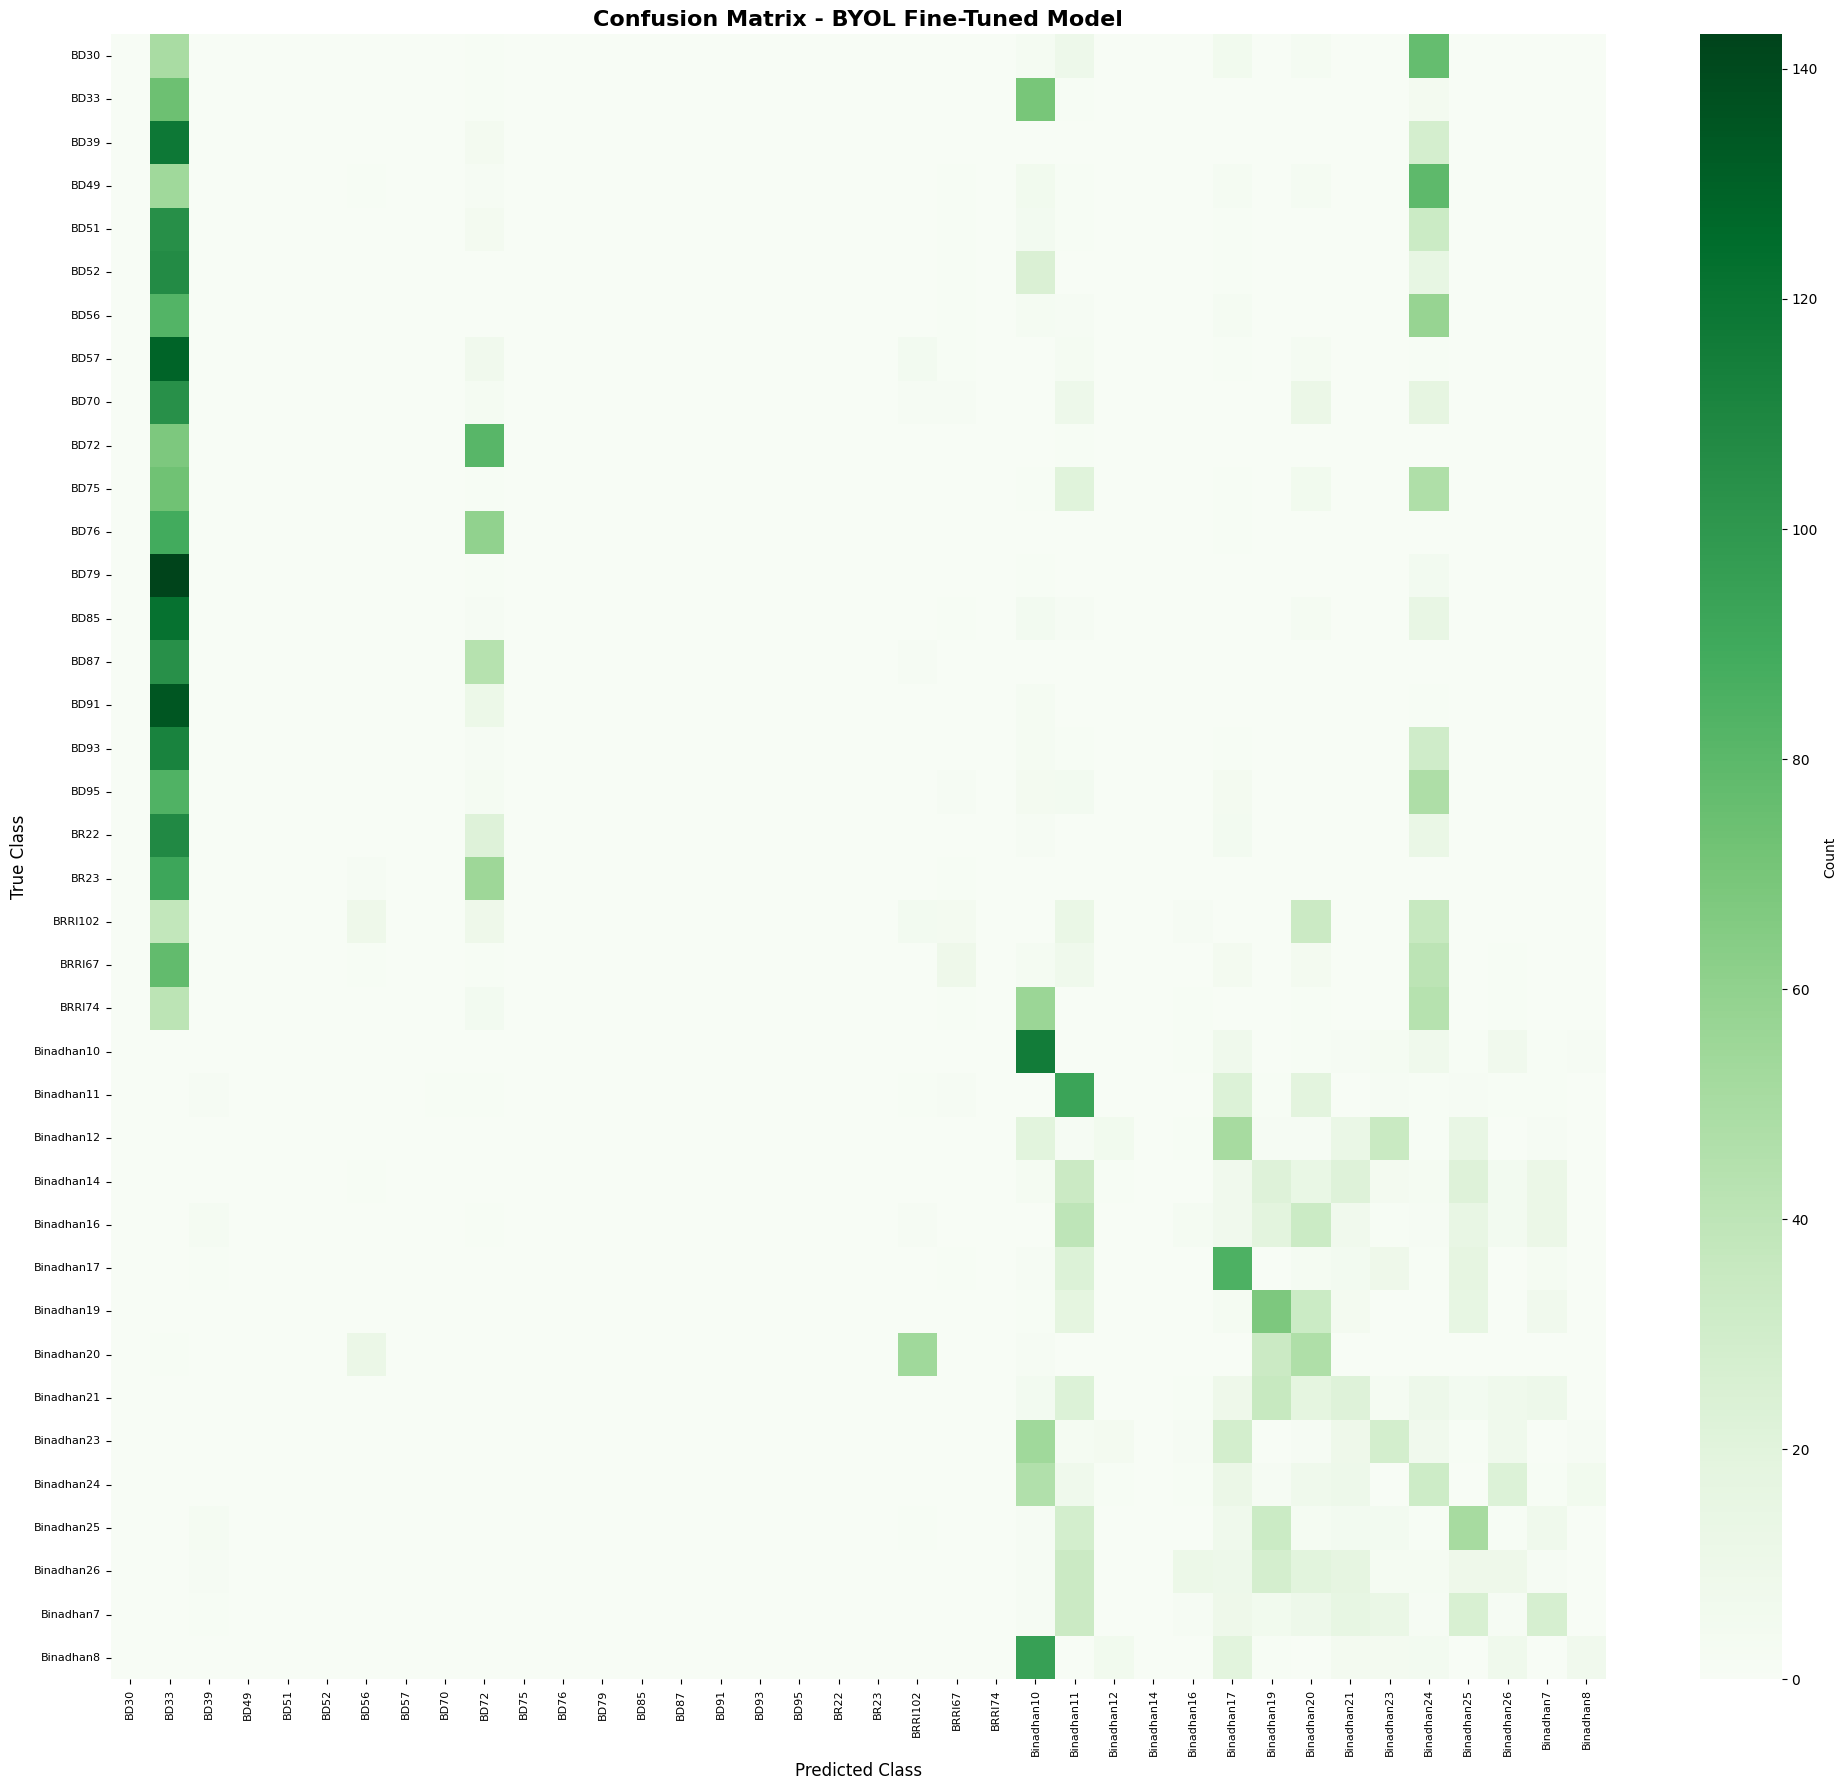

Saved: confusion_matrix_byol.png

PER-CLASS ACCURACY

Top 5 Best Classified Classes:
1. Binadhan10               : 77.33%
2. Binadhan11               : 62.00%
3. Binadhan17               : 56.67%
4. BD72                     : 54.00%
5. BD33                     : 49.33%

Bottom 5 Worst Classified Classes:
1. BD30                     : 0.00%
2. BD39                     : 0.00%
3. BD49                     : 0.00%
4. BD51                     : 0.00%
5. BD56                     : 0.00%

OVERALL STATISTICS
Overall Accuracy:  13.40%
Precision:         0.1019
Recall:            0.1340
F1-Score:          0.0895
Mean Class Acc:    13.40%
Std Dev:           21.30%


In [17]:
print("="*80)
print("CONFUSION MATRIX - BYOL FINE-TUNED")
print("="*80)

# Ensure byol_finetune is in eval mode
byol_finetune.eval()
finetune_preds, finetune_labels = [], []

with torch.no_grad():
    for images, labels in eval_test_loader:
        images = images.to(device)
        
        # Forward pass: encoder → projection → predictor
        h = byol_finetune.student_encoder(images)
        h = torch.flatten(h, start_dim=1)
        z = byol_finetune.student_projection(h)
        logits = byol_finetune.student_predictor(z)
        
        finetune_preds.append(logits.argmax(dim=1).cpu())
        finetune_labels.append(labels)

finetune_preds = torch.cat(finetune_preds).numpy()
finetune_labels = torch.cat(finetune_labels).numpy()

# Compute confusion matrix
cm = confusion_matrix(finetune_labels, finetune_preds)

# Plot confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Greens',
            xticklabels=eval_test_dataset.class_names,
            yticklabels=eval_test_dataset.class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - BYOL Fine-Tuned Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix_byol.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: confusion_matrix_byol.png")

# Compute per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Handle NaN values (if any class has no samples)
per_class_acc = np.nan_to_num(per_class_acc, nan=0.0)

print("\n" + "="*80)
print("PER-CLASS ACCURACY")
print("="*80)

# Top 5 Best Classified
print("\nTop 5 Best Classified Classes:")
top_5_idx = np.argsort(per_class_acc)[-5:][::-1]
for rank, idx in enumerate(top_5_idx, 1):
    class_name = eval_test_dataset.class_names[idx]
    accuracy = per_class_acc[idx] * 100
    print(f"{rank}. {class_name:<25}: {accuracy:.2f}%")

# Bottom 5 Worst Classified
print("\nBottom 5 Worst Classified Classes:")
bottom_5_idx = np.argsort(per_class_acc)[:5]
for rank, idx in enumerate(bottom_5_idx, 1):
    class_name = eval_test_dataset.class_names[idx]
    accuracy = per_class_acc[idx] * 100
    print(f"{rank}. {class_name:<25}: {accuracy:.2f}%")

# Overall statistics
print("\n" + "="*80)
print("OVERALL STATISTICS")
print("="*80)
overall_acc = accuracy_score(finetune_labels, finetune_preds)
precision, recall, f1, _ = precision_recall_fscore_support(finetune_labels, finetune_preds, average='weighted', zero_division=0)

print(f"Overall Accuracy:  {overall_acc*100:.2f}%")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"F1-Score:          {f1:.4f}")
print(f"Mean Class Acc:    {per_class_acc.mean()*100:.2f}%")
print(f"Std Dev:           {per_class_acc.std()*100:.2f}%")


FINE-TUNING LEARNING CURVES


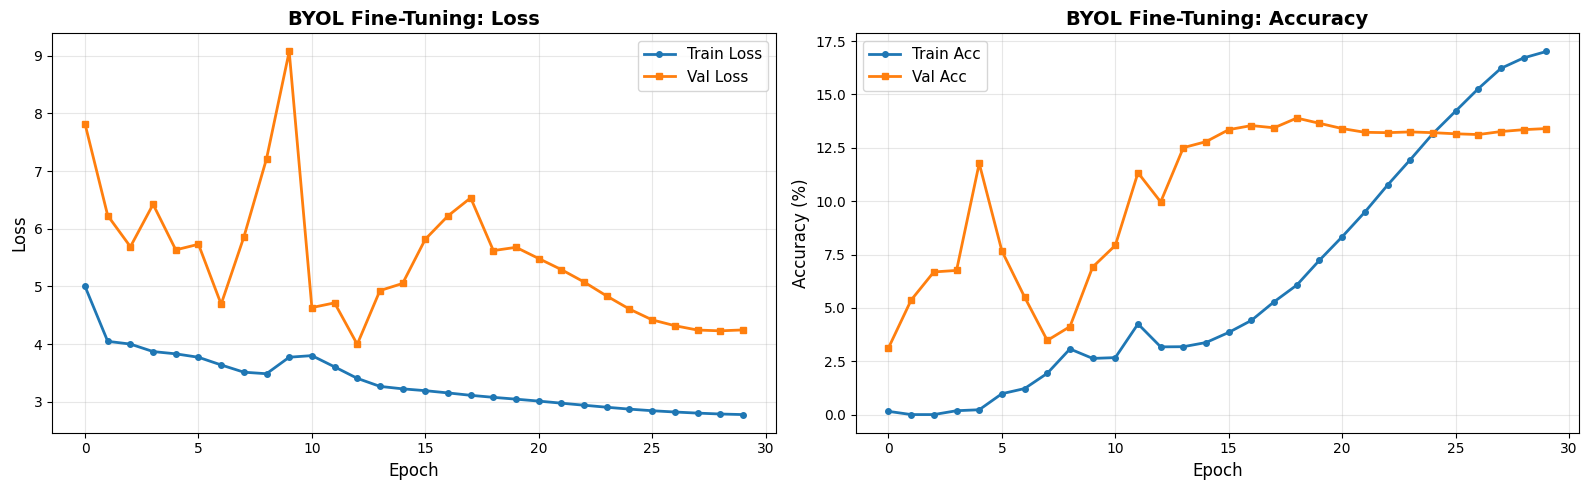

Saved: byol_finetuning_curves.png


In [18]:
print("="*80)
print("FINE-TUNING LEARNING CURVES")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss curves
axes[0].plot(finetune_history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[0].plot(finetune_history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('BYOL Fine-Tuning: Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(finetune_history['train_acc'], label='Train Acc', linewidth=2, marker='o', markersize=4)
axes[1].plot(finetune_history['val_acc'], label='Val Acc', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('BYOL Fine-Tuning: Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('byol_finetuning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: byol_finetuning_curves.png")


# CELL 14: t-SNE & PCA Visualizations

EMBEDDING VISUALIZATION - BYOL
Visualizing 3000 samples

1. t-SNE...
2. PCA...

Silhouette Scores:
  t-SNE: -0.1725
  PCA:   -0.3973


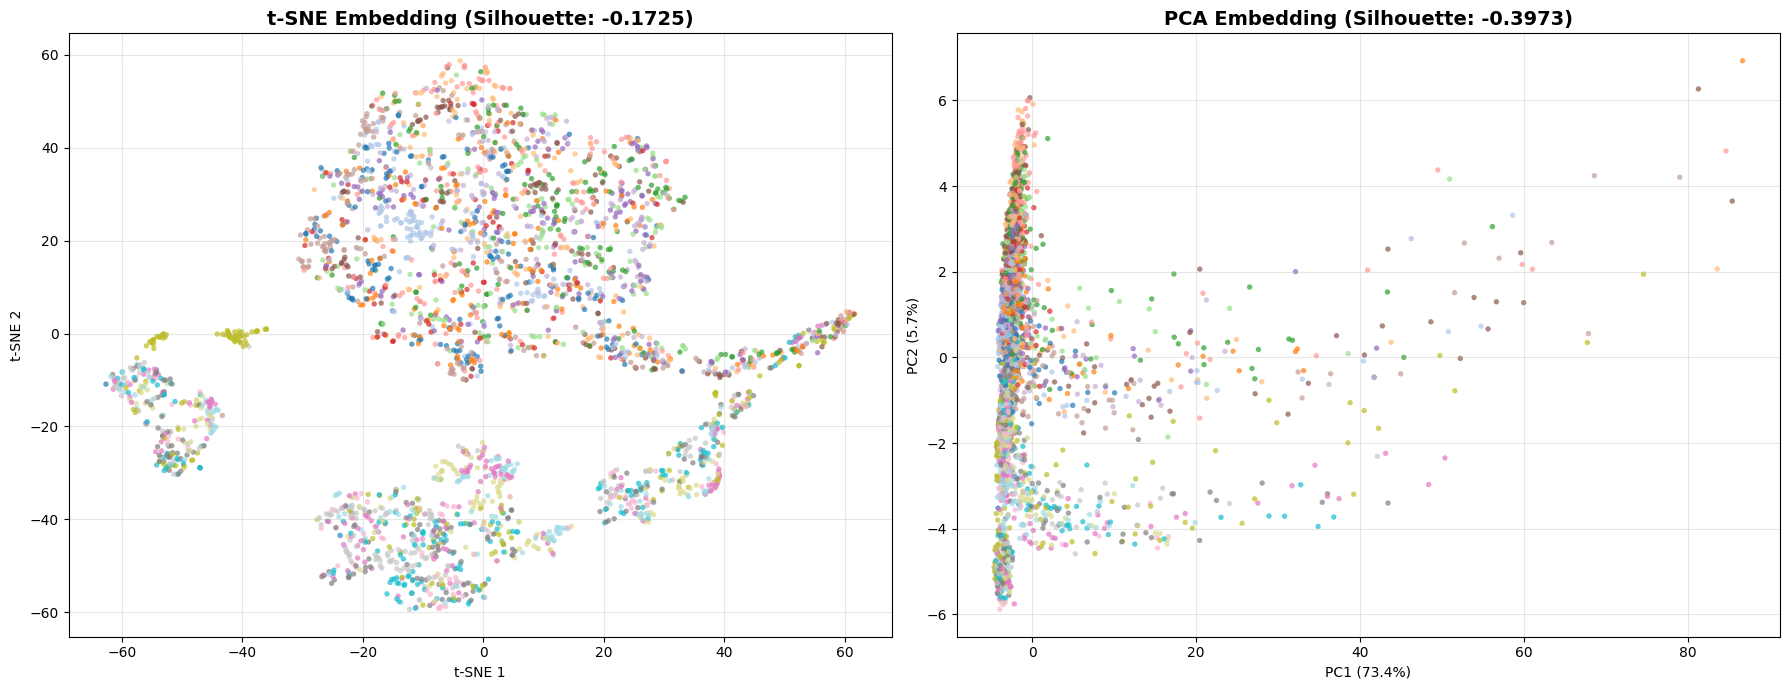

Saved: embedding_visualizations_byol.png


In [19]:
print("="*80)
print("EMBEDDING VISUALIZATION - BYOL")
print("="*80)

X_vis = test_features.numpy()
y_vis = test_labels.numpy()
if len(X_vis) > 3000:
    sample_idx = np.random.choice(len(X_vis), 3000, replace=False)
    X_vis_sample = X_vis[sample_idx]
    y_vis_sample = y_vis[sample_idx]
else:
    X_vis_sample = X_vis
    y_vis_sample = y_vis

print(f"Visualizing {len(X_vis_sample)} samples")

print("\n1. t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_vis_sample)

print("2. PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_vis_sample)

silhouette_tsne = silhouette_score(X_tsne, y_vis_sample)
silhouette_pca = silhouette_score(X_pca, y_vis_sample)

print(f"\nSilhouette Scores:")
print(f"  t-SNE: {silhouette_tsne:.4f}")
print(f"  PCA:   {silhouette_pca:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_vis_sample, cmap='tab20', alpha=0.7, s=15, edgecolors='none')
axes[0].set_title(f't-SNE Embedding (Silhouette: {silhouette_tsne:.4f})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_vis_sample, cmap='tab20', alpha=0.7, s=15, edgecolors='none')
axes[1].set_title(f'PCA Embedding (Silhouette: {silhouette_pca:.4f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embedding_visualizations_byol.png', dpi=300)
plt.show()

print("Saved: embedding_visualizations_byol.png")


# CELL 15: Learning Curves

LEARNING CURVES - BYOL


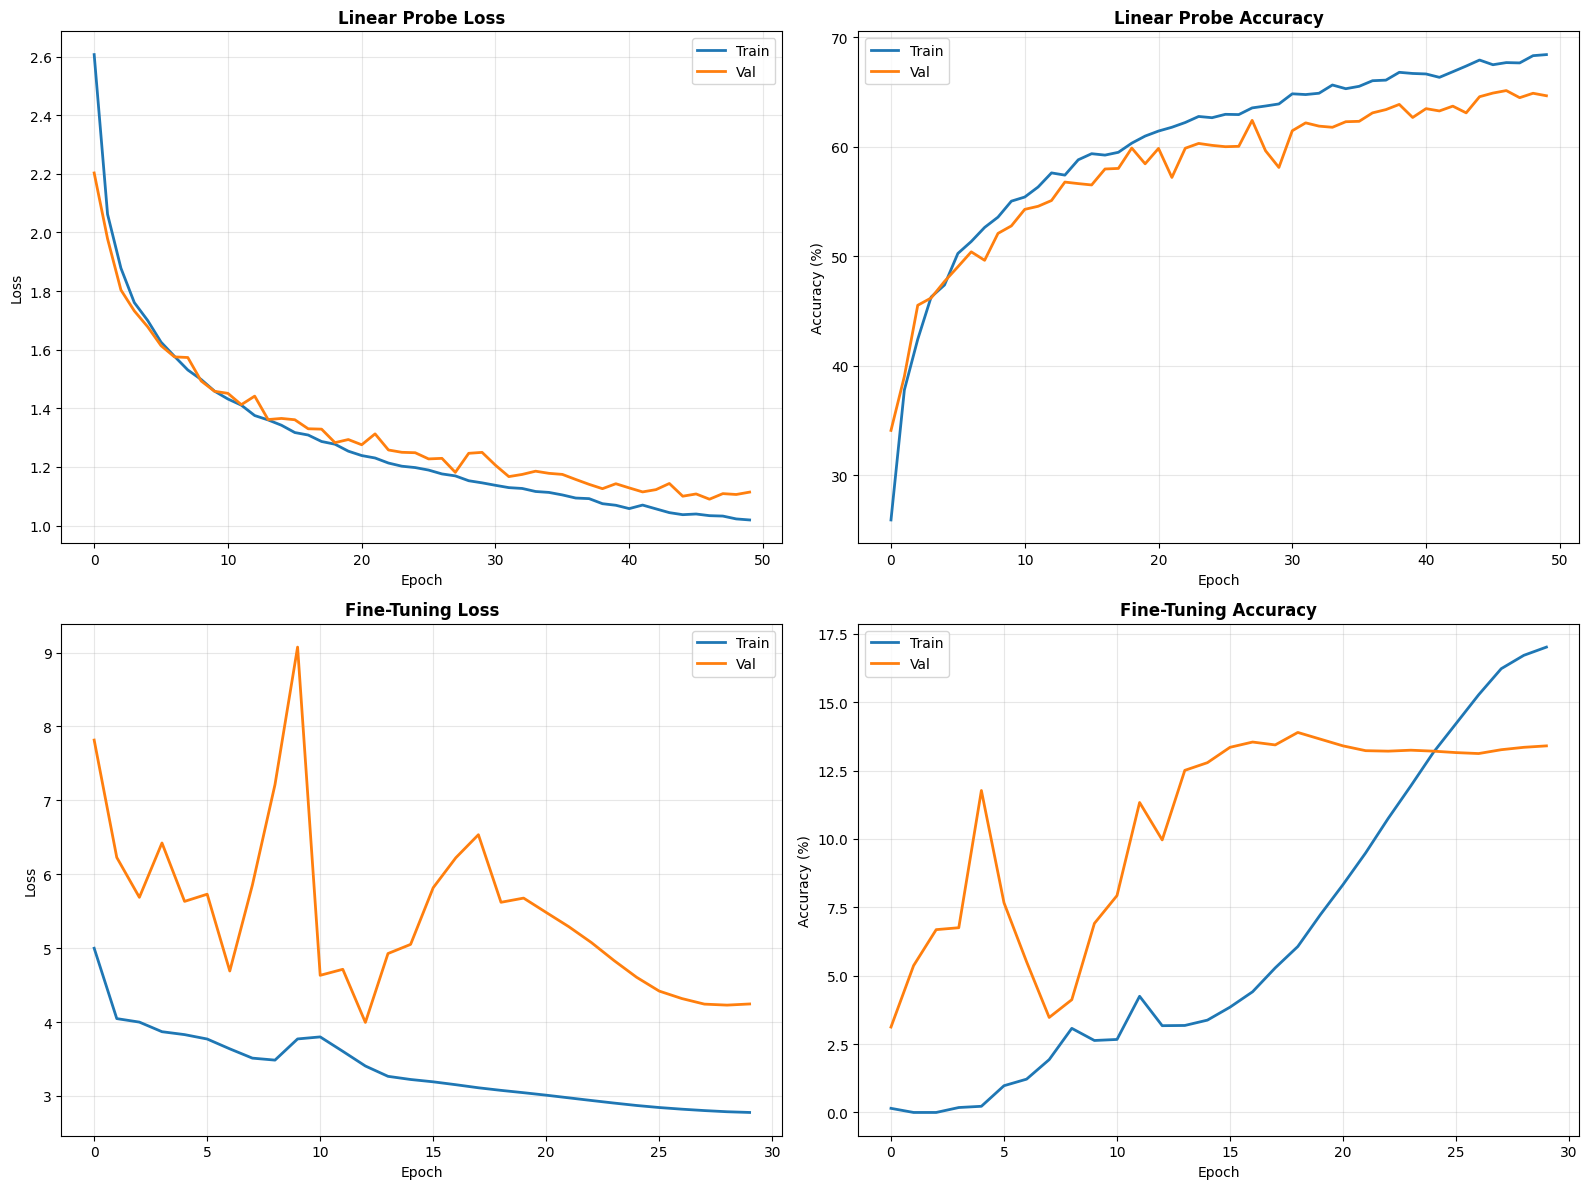

In [20]:
print("="*80)
print("LEARNING CURVES - BYOL")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(linear_history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(linear_history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_title('Linear Probe Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(linear_history['train_acc'], label='Train', linewidth=2)
axes[0, 1].plot(linear_history['val_acc'], label='Val', linewidth=2)
axes[0, 1].set_title('Linear Probe Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(finetune_history['train_loss'], label='Train', linewidth=2)
axes[1, 0].plot(finetune_history['val_loss'], label='Val', linewidth=2)
axes[1, 0].set_title('Fine-Tuning Loss', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(finetune_history['train_acc'], label='Train', linewidth=2)
axes[1, 1].plot(finetune_history['val_acc'], label='Val', linewidth=2)
axes[1, 1].set_title('Fine-Tuning Accuracy', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves_byol.png', dpi=300)
plt.show()


# CELL 16: Final Results Summary

In [21]:
print("="*80)
print("TASK 5 BYOL - FINAL RESULTS")
print("="*80)

# Task 2 baseline
task2_baseline = {'ResNet50 (60:40)': 75.0, 'DenseNet121 (80:20)': 74.11}
best_baseline_acc = max(task2_baseline.values())

# Task 4 SimCLR results
simclr_linear = 50.93

# Task 5 BYOL results
byol_linear = linear_history['val_acc'][-1]
byol_mlp = shallow_results['MLP']['accuracy'] * 100
byol_svm = shallow_results['SVM']['accuracy'] * 100
byol_dt = shallow_results['Decision Tree']['accuracy'] * 100
byol_rf = shallow_results['Random Forest']['accuracy'] * 100
byol_finetune = finetune_history['val_acc'][-1]

results_df = pd.DataFrame({
    'Method': ['Linear Probe', 'MLP', 'SVM', 'Decision Tree', 'Random Forest', 'Fine-Tuned'],
    'BYOL Accuracy (%)': [f"{byol_linear:.2f}", f"{byol_mlp:.2f}", f"{byol_svm:.2f}", 
                          f"{byol_dt:.2f}", f"{byol_rf:.2f}", f"{byol_finetune:.2f}"],
    'vs Task2 Baseline': [f"{byol_linear - best_baseline_acc:+.2f}%", 
                         f"{byol_mlp - best_baseline_acc:+.2f}%",
                         f"{byol_svm - best_baseline_acc:+.2f}%",
                         f"{byol_dt - best_baseline_acc:+.2f}%",
                         f"{byol_rf - best_baseline_acc:+.2f}%",
                         f"{byol_finetune - best_baseline_acc:+.2f}%"],
    'vs SimCLR': [f"{byol_linear - simclr_linear:+.2f}%",
                  f"{byol_mlp - simclr_linear:+.2f}%",
                  f"{byol_svm - simclr_linear:+.2f}%",
                  f"{byol_dt - simclr_linear:+.2f}%",
                  f"{byol_rf - simclr_linear:+.2f}%",
                  f"{byol_finetune - simclr_linear:+.2f}%"]
})

print("\n" + "="*80)
print("COMPARISON TABLE")
print("="*80)
print(results_df.to_string(index=False))

results_df.to_csv('byol_results_summary.csv', index=False)
print("\nSaved: byol_results_summary.csv")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"Task 2 Best Baseline:      {best_baseline_acc:.2f}%")
print(f"Task 4 SimCLR Linear:      {simclr_linear:.2f}%")
print(f"Task 5 BYOL Linear Probe:  {byol_linear:.2f}%")
print(f"Task 5 BYOL Best Result:   {max(byol_linear, byol_mlp, byol_svm, byol_dt, byol_rf, byol_finetune):.2f}%")
print(f"Improvement vs Baseline:   {max(byol_linear, byol_mlp, byol_svm, byol_dt, byol_rf, byol_finetune) - best_baseline_acc:+.2f}%")


TASK 5 BYOL - FINAL RESULTS

COMPARISON TABLE
       Method BYOL Accuracy (%) vs Task2 Baseline vs SimCLR
 Linear Probe             64.65           -10.35%   +13.72%
          MLP             72.75            -2.25%   +21.82%
          SVM             54.60           -20.40%    +3.67%
Decision Tree             40.88           -34.12%   -10.05%
Random Forest             59.96           -15.04%    +9.03%
   Fine-Tuned             13.40           -61.60%   -37.53%

Saved: byol_results_summary.csv

KEY FINDINGS
Task 2 Best Baseline:      75.00%
Task 4 SimCLR Linear:      50.93%
Task 5 BYOL Linear Probe:  64.65%
Task 5 BYOL Best Result:   72.75%
Improvement vs Baseline:   -2.25%


# CELL 17: Deliverables Checklist

In [ ]:
print("="*80)
print("TASK 5 DELIVERABLES")
print("="*80)

files_to_check = [
    'byol_pretrained_encoder.pth',
    'byol_features.pth',
    'byol_linear_classifier.pth',
    'byol_finetuned.pth',
    'byol_training_curves.png',
    'confusion_matrix_byol.png',
    'embedding_visualizations_byol.png',
    'learning_curves_byol.png',
    'byol_results_summary.csv'
]

print("\nFiles generated:")
for f in files_to_check:
    exists = os.path.exists(f)
    status = "[✓]" if exists else "[MISSING]"
    size = f"{os.path.getsize(f) / (1024**2):.2f} MB" if exists else "N/A"
    print(f"  {status} {f:<40} {size}")

print("\n" + "="*80)
print("TASK 5 COMPLETE")
print("="*80)
